# Multi-Scale Generalization on AudioMNIST with SITHCon

For a more detailed look, check out the following paper published in PMLR: [A deep convolutional neural network that is invariant to time rescaling](https://proceedings.mlr.press/v162/jacques22a.html)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/compmem/sithshow/blob/main/examples/audio_mnist.ipynb)

In [1]:
!pip install -q SITHshow@git+https://github.com/compmem/SITHshow


[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from sithshow import model_utils, SITHCon_Classifier
from sithshow.dataset_utils import dataloader, random_split

import jax
import jax.numpy as jnp
import jax.random as jrandom
import optax
import equinox as eqx

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import urllib.request as request
import os

In [4]:
# Load in the data stored on Open Science Framework. (1,000 samples of the unscaled data, 300 samples for each
# scaled dataset). You can find versions of the processed data with many more samples here: https://osf.io/5a9xs/

if not os.path.exists('./data'):
    os.makedirs('./data')
    
scales = ['0_40', '0_80', '1_00', '1_25', '2_50']
web_dirs = ['rcdsv', 'rmwq5', 'uefhk', 'gkhd5', 'cw2sr']
scaled_datasets = {}

for web_dir, scale in zip(web_dirs, scales):
    if not os.path.exists(f'./data/scale_{scale}.npz'):
        request.urlretrieve(f'https://osf.io/{web_dir}/?action=download&version=1', f'./data/scale_{scale}.npz')

    dat = np.load(f'./data/scale_{scale}.npz')
    scaled_datasets[scale] = dat['X'], dat['Y']    

Text(0.5, 1.0, 'Spectrogram for digit 2 at timescale 1_25')

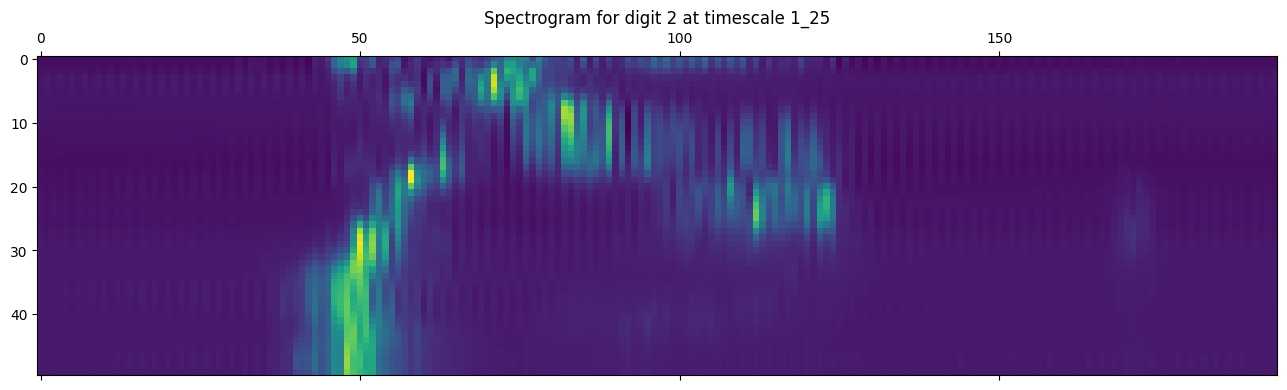

In [5]:
# Plot an example
time_scale = '1_25'
dat_ind = 2

plt.matshow(scaled_datasets[time_scale][0][dat_ind])
plt.title(f"Spectrogram for digit {scaled_datasets['1_00'][1][dat_ind]} at timescale {time_scale}")

In [5]:
# Hyperparameters:
BATCH_SIZE=10
LEARNING_RATE=3e-3
STEPS=50
SEED=5678

key = jrandom.PRNGKey(SEED)

# The longest sequence we're training on is length 250, so a tau_max of 300 will ensure 
# we're able to store all of the information in the sequence in the SITH working memory (and then some!)

sith_params = {'tau_min':.5, # the center of the first temporal receptive field 
               'tau_max': 300, # the center of the last temporal receptive field
               'n_taus': 50} # the number of (log-spaced) temporal receptive fields

sithcon = SITHCon_Classifier(in_size=50, 
                             out_size=10,
                             sith_params=sith_params,
                             key=key)

sithcon = model_utils.cast_params_to_float32(sithcon)

In [6]:
# functions to optimize SITHCon params

optim = optax.adam(LEARNING_RATE)
opt_state = optim.init(eqx.filter(sithcon, eqx.is_array))

@eqx.filter_value_and_grad
def compute_loss(model, x, y):
    pred_logits = jax.vmap(model)(x)

    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(pred_logits, y))

@eqx.filter_jit
def make_step(model, x, y, opt_state):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    
    return loss, model, opt_state

In [7]:
# We'll train on the normal scale
X, Y = scaled_datasets['1_00']
train_X, train_Y, test_X, test_Y = random_split(X, Y, train_proportion=.8)
train_X, train_Y = jnp.asarray(train_X), jnp.asarray(train_Y)

iter_data = dataloader((train_X, train_Y), BATCH_SIZE)

losses = []

for step, (x, y) in tqdm(zip(range(STEPS), iter_data)):
    loss, sithcon, opt_state = make_step(sithcon, x, y, opt_state)
    losses.append(loss.item())

0it [00:00, ?it/s]

50it [01:19,  1.59s/it]


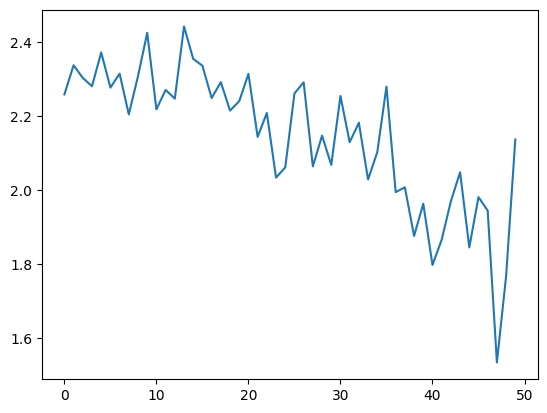

In [8]:
plt.plot(losses);

In [19]:
def get_avg_acc(X, Y):
    batch_model = jax.vmap(sithcon)
    total_acc = 0.0
    n_terms = 0

    iter_data = dataloader([X, Y], BATCH_SIZE, n_passes=1)

    for (x, y) in iter_data:
        pred = np.argmax(batch_model(x), 1)    
        acc = np.sum(pred == y) / len(x)

        total_acc += acc 
        n_terms += 1
        
    return total_acc / n_terms 

In [20]:
# accuracy on the testing set (same scale) after training
acc_scale_1 = get_avg_acc(test_X, test_Y).item()
print(acc_scale_1)

0.325


In [21]:
# The computational cost of running SITHCon increases with the number of temporal receptive fields (taus).
# To save compute, we can train on short sequences with a small working memory. Then, we can increase 
# the working memory of SITH post-hoc and rely on the scale-invariant property of SITHCon to generalize
# to longer timescales!

sithcon = model_utils.increase_n_taus_sithcon(sithcon, 600) # TODO: currently a hack in the backend

In [22]:
# Evaluate the model on rescaled data

scales = ['0_40', '0_80', '1_00', '1_25', '2_50']  
accs = []

for scale in scales:
    if scale == '1_00':
        accs.append(acc_scale_1)
    else:
        X, Y = scaled_datasets[scale]
        accs.append(get_avg_acc(X, Y).item())

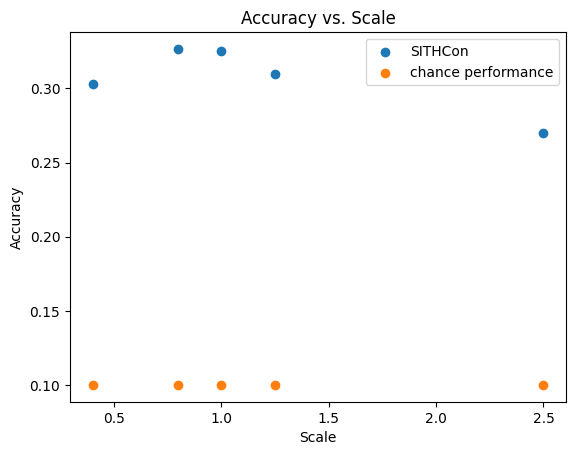

In [23]:
# With sufficient training and hyperparameter tuning, SITHCon can reach 100% accuracy
# on a range of timescales. Can you tune the hyperparameters to improve performance? 

scale_factors = [.4, .8, 1., 1.25, 2.5]

plt.scatter(scale_factors, accs, label='SITHCon')
plt.scatter(scale_factors, np.ones(len(scale_factors))/10, label='chance performance')
plt.xlabel('Scale')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Scale')
plt.legend();